In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, datasets
from sklearn.semi_supervised import LabelSpreading


In [5]:
# 加载数据 这里使用sklearn自带的糖尿病数据
def load_data():
    '''
    加载数据集
    返回一个元祖，依次是：样本集合、样本标记集合、未标记样本的下标集合
    '''
    digits = datasets.load_digits()
    ### 混洗样本 ###
    rng = np.random.RandomState(0)
    indices = np.arange(len(digits.data)) # 样本的下标集合
    
    rng.shuffle(indices) # 混洗样本下标集合
    X = digits.data[indices]
    Y = digits.target[indices]
    ### 生成未标记样本的下标集合 ###
    n_labeled_points = int(len(Y)/10)  # 总样本数除以10 ，即只有十分之一的数据有标记
    unlabeled_indices = np.arange(len(Y))[n_labeled_points:] # 其余的样本未标记
    
    return X, Y, unlabeled_indices

In [6]:
def test_LabelSpreading(*data):
    '''
    测试 LabelSpreading 的用法

    :param data: 一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return: None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1
    clf=LabelSpreading(max_iter=100,kernel='rbf',gamma=0.1)
    clf.fit(X,y_train)
    ### 获取预测准确率
    predicted_labels = clf.transduction_[unlabeled_indices] # 预测标记
    true_labels = y[unlabeled_indices] # 真实标记
    print("Accuracy:%f"%metrics.accuracy_score(true_labels,predicted_labels))
    # 或者 print("Accuracy:%f"%clf.score(X[unlabeled_indices],true_labels))

X, Y, unlabeled_indices = load_data()
test_LabelSpreading(X, Y, unlabeled_indices)

Accuracy:0.972806


/usr/local/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


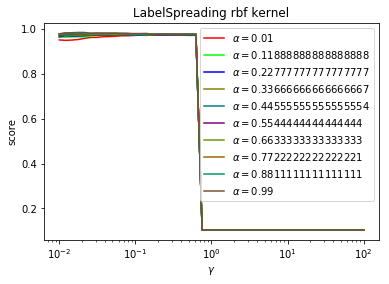

In [8]:
# rbf核 及其参数的影响
def test_LabelSpreading_rbf(*data):
    '''
    测试 LabelSpreading 的 rbf 核时，预测性能随 alpha 和 gamma 的变化

    :param data: 一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return: None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    alphas=np.linspace(0.01,0.99,num=10,endpoint=True)
    gammas=np.logspace(-2,2,num=50)
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
        (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),) # 颜色集合，不同曲线用不同颜色
    ## 训练并绘图
    for alpha,color in zip(alphas,colors):
        scores=[]
        for gamma in gammas:
            clf=LabelSpreading(max_iter=100,gamma=gamma,alpha=alpha,kernel='rbf')
            clf.fit(X,y_train)
            scores.append(clf.score(X[unlabeled_indices],y[unlabeled_indices]))
        ax.plot(gammas,scores,label=r"$\alpha=%s$"%alpha,color=color)

    ### 设置图形
    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel("score")
    ax.set_xscale("log")
    ax.legend(loc="best")
    ax.set_title("LabelSpreading rbf kernel")
    plt.show()
    

X, Y, unlabeled_indices = load_data()
test_LabelSpreading_rbf(X, Y, unlabeled_indices)

/usr/local/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=100 was reached without convergence.
  category=ConvergenceWarning


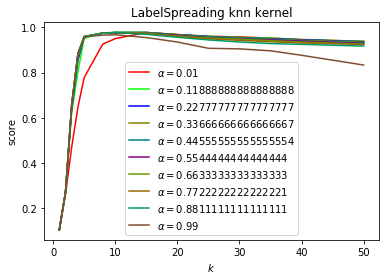

In [9]:
def test_LabelSpreading_knn(*data):
    '''
   测试 LabelSpreading 的 knn 核时，预测性能随 alpha 和 n_neighbors 的变化


    :param data:  一个元组，依次为： 样本集合、样本标记集合、 未标记样本的下标集合
    :return:  None
    '''
    X,y,unlabeled_indices=data
    y_train=np.copy(y) # 必须拷贝，后面要用到 y
    y_train[unlabeled_indices]=-1 # 未标记样本的标记设定为 -1

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    alphas=np.linspace(0.01,0.99,num=10,endpoint=True)
    Ks=[1,2,3,4,5,8,10,15,20,25,30,35,40,50]
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
        (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),) # 颜色集合，不同曲线用不同颜色
    ## 训练并绘图
    for alpha,color in zip(alphas,colors):
        scores=[]
        for K in Ks:
            clf=LabelSpreading(kernel='knn',max_iter=100,n_neighbors=K,alpha=alpha)
            clf.fit(X,y_train)
            scores.append(clf.score(X[unlabeled_indices],y[unlabeled_indices]))
        ax.plot(Ks,scores,label=r"$\alpha=%s$"%alpha,color=color)

    ### 设置图形
    ax.set_xlabel(r"$k$")
    ax.set_ylabel("score")
    ax.legend(loc="best")
    ax.set_title("LabelSpreading knn kernel")
    plt.show()
    
data=load_data() # 获取半监督分类数据集
test_LabelSpreading_knn(*data)